# RNN: 순환신경망
- 글자, 문장
- 문자의 단계를 알기 위해 순환셀 사용
    - cell: RNN에서 은닉층에서 활성화 함수를 통해 결과를 내보내는 역할을 하는 노드


In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

### IMDB (Internet Movie Data Base)
- Train Data (25000 중 긍정 12500, 부정 12500)
- Test Data (25000 중 긍정 12500, 부정 12500)
- NLP (Natural Language Processing: 자연어 처리)
- 말뭉치: 데이터셋
- 토큰: 단어
- 어휘사전: 어떤 단어에 대해 일련 번호를 부여한 것

In [4]:
from tensorflow.keras.datasets import imdb

In [5]:
(train_input, train_target),(test_input,test_target) = imdb.load_data(num_words=500)

17464789/17464789 [==============================] - 4s 0us/step


In [6]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [7]:
# train의 첫 번째 문장의 token (단어) 출력
len(train_input[0])
# 218 단어로 구성

218

In [8]:
# 첫 번째 댓글 출력
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


- sample의 시작부분은 토큰을 1로 사용.
- 2는 선정된 단어 개수에 포함되지 않는 단어를 표현할 때 사용.
- train_input 자체는 numpy 배열이나 사용자마다 댓글에 사용한 토큰의 수가 다르기 때문에 numpy 배열을 사용하지 못하고 python list를 사용한다.

In [10]:
# train_target 출력
print(train_target[:10])
# 1은 긍정, 0은 부정

[1 0 0 1 0 0 1 0 1 0]


### 훈련세트 준비

In [11]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input,train_target,test_size=0.2,random_state=42)

In [12]:
# 각 리뷰마다 문장 길이를 시각화
lengths = np.array([len(x) for x in train_input])
print(np.mean(lengths), np.median(lengths))
# 239.00925, 178.0

239.00925 178.0


> 중앙값보다 평균이 크므로 예상치 않게 길게 달린 댓글이 있다고 예측 가능 (Skewed-right)

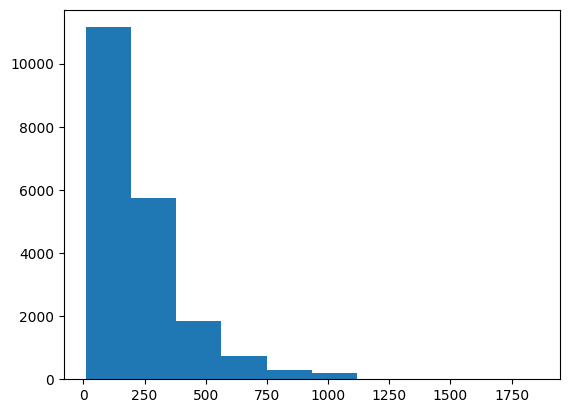

In [14]:
plt.hist(lengths)
plt.show()

---
### Sequence Padding
- 전체 자릿수를 100으로 가정했을 때, 한 문장에 3개 토큰만 있을 경우 나머지 97개는 비워지고 이를 0으로 채우는 과정.

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
train_seq = pad_sequences(train_input,maxlen=100)
val_seq = pad_sequences(val_input,maxlen=100)

In [20]:
# 크기 확인
print(train_seq.shape)
print(val_seq.shape)

(20000, 100)
(5000, 100)


In [21]:
# 첫 번째 댓글 확인
print(train_seq[0])
# 1이 없음 (앞 부분이 짤림)

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [22]:
print(train_seq[5])
# 0으로 채워짐 (100보다 작다, 1부터 시작)

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


---
### 순환신경망 모델 만들기

In [23]:
from tensorflow import keras

In [24]:
model = keras.Sequential()
# one-hot encoding이 필요하므로 500
model.add(keras.layers.SimpleRNN(8,input_shape=(100,500)))
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [25]:
# one-hot encoding
train_oh = keras.utils.to_categorical(train_seq)
print(train_oh.shape)

(20000, 100, 500)


In [26]:
val_oh = keras.utils.to_categorical(val_seq)
print(val_oh.shape)

(5000, 100, 500)


In [29]:
# 0.0001
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Data/best_simple_rnn_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history = model.fit(train_oh,train_target,epochs=100,batch_size=64,validation_data=(val_oh,val_target),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 17ms/step - loss: 0.6874 - accuracy: 0.5496 - val_loss: 0.6847 - val_accuracy: 0.5624
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6774 - accuracy: 0.5894 - val_loss: 0.6749 - val_accuracy: 0.5976
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6661 - accuracy: 0.6191 - val_loss: 0.6631 - val_accuracy: 0.6212
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6520 - accuracy: 0.6467 - val_loss: 0.6488 - val_accuracy: 0.6528
Epoch 5/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6358 - accuracy: 0.6708 - val_loss: 0.6340 - val_accuracy: 0.6760
Epoch 6/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6186 - accuracy: 0.6926 - val_loss: 0.6162 - val_accuracy: 0.6942
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6010 - accuracy: 0.7094 - val_loss: 0.5994 - val_accuracy:

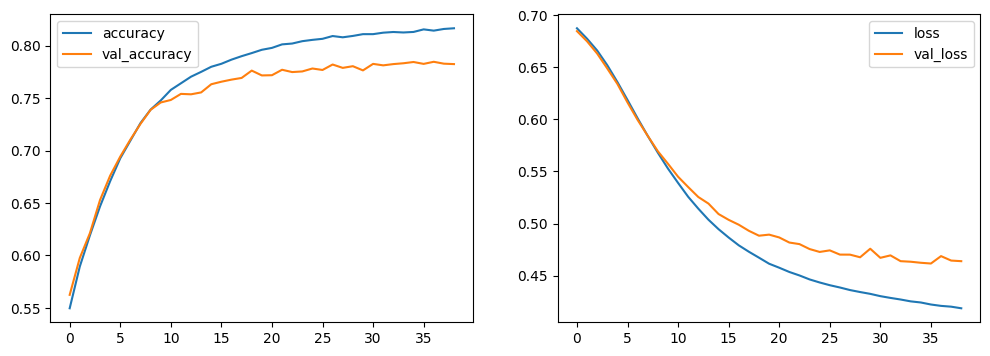

In [41]:
plt.figure(figsize=(12,4))
fig1 = plt.subplot(1,2,1)
fig2 = plt.subplot(1,2,2)
fig1.plot(history.history['accuracy'])
fig1.plot(history.history['val_accuracy'])
fig2.plot(history.history['loss'])
fig2.plot(history.history['val_loss'])
fig1.legend(['accuracy','val_accuracy'])
fig2.legend(['loss','val_loss'])
plt.show()

> 전체 데이터 중 100개만 사용했으므로 나쁘지 않은 결과

In [43]:
model.evaluate(val_oh,val_target)

157/157 [==============================] - 1s 5ms/step - loss: 0.4617 - accuracy: 0.7826


[0.4616606831550598, 0.7825999855995178]

---
# LSTM 신경망 모델 구성하기
- RNN의 일종인 Long Short-Term Memory models (LSTM)
- 단어 횟수 기반 언어모델 (one-hot encoding)의 한계를 극복 (단어 간의 의미(Semantic) 관계 보존)

### Embedding
- input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- output_dim: Integer. Dimension of the dense embedding.

In [55]:
# input 1:
model = keras.Sequential()
# Embedding(input_dim, output_dim)
model.add(keras.layers.Embedding(500,16,input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1,activation='sigmoid'))

# input 2:
# ip = keras.layers.Input((100))
# emb = keras.layers.Embedding(500, 16)(ip)
# lstm = keras.layers.LSTM(8)(emb)
# out = keras.layers.Dense(1, activation='sigmoid')(lstm)
# model = keras.models.Model(ip, out)

In [56]:
print(train_seq.shape)
print(train_target.shape)
print(val_seq.shape)
print(val_target.shape)

(20000, 100)
(20000,)
(5000, 100)
(5000,)


In [57]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Data/best_lstm_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history = model.fit(train_seq,train_target,epochs=100,batch_size=64,validation_data=(val_seq,val_target),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 5s 12ms/step - loss: 0.6926 - accuracy: 0.5301 - val_loss: 0.6918 - val_accuracy: 0.5408
Epoch 2/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6899 - accuracy: 0.5846 - val_loss: 0.6879 - val_accuracy: 0.6184
Epoch 3/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6825 - accuracy: 0.6513 - val_loss: 0.6752 - val_accuracy: 0.6626
Epoch 4/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6415 - accuracy: 0.6894 - val_loss: 0.6019 - val_accuracy: 0.7208
Epoch 5/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5789 - accuracy: 0.7406 - val_loss: 0.5694 - val_accuracy: 0.7498
Epoch 6/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5535 - accuracy: 0.7549 - val_loss: 0.5467 - val_accuracy: 0.7644
Epoch 7/100
313/313 [==============================] - 3s 11ms/step - loss: 0.5322 - accuracy: 0.7689 - val_loss: 0.5282 - val_accuracy:

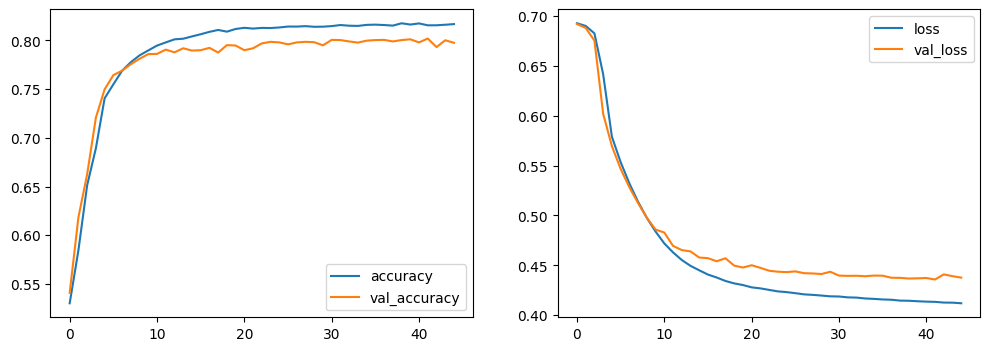

In [58]:
plt.figure(figsize=(12,4))
fig1 = plt.subplot(1,2,1)
fig2 = plt.subplot(1,2,2)
fig1.plot(history.history['accuracy'])
fig1.plot(history.history['val_accuracy'])
fig2.plot(history.history['loss'])
fig2.plot(history.history['val_loss'])
fig1.legend(['accuracy','val_accuracy'])
fig2.legend(['loss','val_loss'])
plt.show()

### 순환층에 드롭아웃 적용하기

In [59]:
model = keras.Sequential()
model.add(keras.layers.Embedding(500,16,input_length=100))
# drop out 추가
model.add(keras.layers.LSTM(8,dropout=0.3))
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [60]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Data/best_lstm_dropout_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history = model.fit(train_seq,train_target,epochs=100,batch_size=64,validation_data=(val_seq,val_target),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 5s 12ms/step - loss: 0.6923 - accuracy: 0.5266 - val_loss: 0.6915 - val_accuracy: 0.5490
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6900 - accuracy: 0.5807 - val_loss: 0.6887 - val_accuracy: 0.6046
Epoch 3/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6857 - accuracy: 0.6194 - val_loss: 0.6830 - val_accuracy: 0.6320
Epoch 4/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6748 - accuracy: 0.6500 - val_loss: 0.6648 - val_accuracy: 0.6366
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6293 - accuracy: 0.6895 - val_loss: 0.6029 - val_accuracy: 0.7320
Epoch 6/100
313/313 [==============================] - 4s 11ms/step - loss: 0.5897 - accuracy: 0.7315 - val_loss: 0.5831 - val_accuracy: 0.7382
Epoch 7/100
313/313 [==============================] - 4s 12ms/step - loss: 0.5709 - accuracy: 0.7451 - val_loss: 0.5640 - val_accuracy:

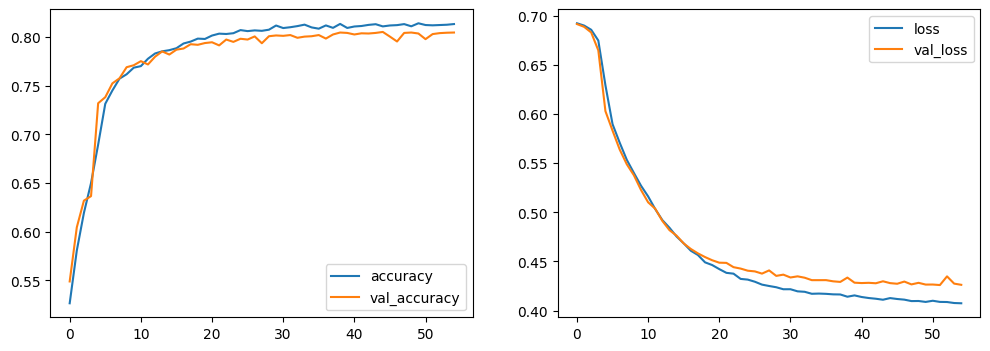

In [61]:
plt.figure(figsize=(12,4))
fig1 = plt.subplot(1,2,1)
fig2 = plt.subplot(1,2,2)
fig1.plot(history.history['accuracy'])
fig1.plot(history.history['val_accuracy'])
fig2.plot(history.history['loss'])
fig2.plot(history.history['val_loss'])
fig1.legend(['accuracy','val_accuracy'])
fig2.legend(['loss','val_loss'])
plt.show()

In [62]:
model.evaluate(val_seq,val_target)

157/157 [==============================] - 0s 2ms/step - loss: 0.4260 - accuracy: 0.8030


[0.42596983909606934, 0.8029999732971191]

## 2개 층을 연결하기

In [69]:
model = keras.Sequential()
model.add(keras.layers.Embedding(500,16,input_length=100))
# return_sequences=True
model.add(keras.layers.LSTM(8,dropout=0.3, return_sequences=True))
# 순환층 추가 (return_sequences=False)
# model.add(keras.layers.LSTM(8,dropout=0.3))
model.add(keras.layers.LSTM(16,dropout=0.3))
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [70]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Data/best_lstm2_dropout_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history = model.fit(train_seq,train_target,epochs=100,batch_size=64,validation_data=(val_seq,val_target),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 26ms/step - loss: 0.6929 - accuracy: 0.5183 - val_loss: 0.6925 - val_accuracy: 0.5468
Epoch 2/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6909 - accuracy: 0.5742 - val_loss: 0.6878 - val_accuracy: 0.6498
Epoch 3/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6557 - accuracy: 0.6501 - val_loss: 0.6067 - val_accuracy: 0.6818
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5835 - accuracy: 0.7015 - val_loss: 0.5529 - val_accuracy: 0.7290
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5425 - accuracy: 0.7327 - val_loss: 0.5243 - val_accuracy: 0.7450
Epoch 6/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5143 - accuracy: 0.7537 - val_loss: 0.4950 - val_accuracy: 0.7644
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4976 - accuracy: 0.7627 - val_loss: 0.4824 - val_accuracy

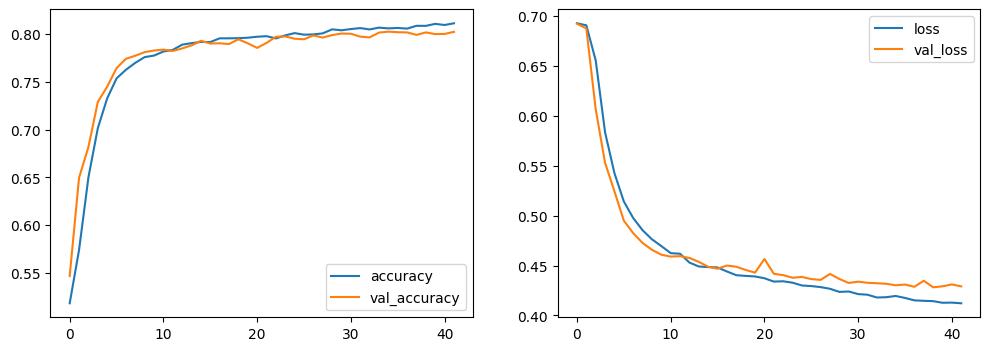

In [72]:
plt.figure(figsize=(12,4))
fig1 = plt.subplot(1,2,1)
fig2 = plt.subplot(1,2,2)
fig1.plot(history.history['accuracy'])
fig1.plot(history.history['val_accuracy'])
fig2.plot(history.history['loss'])
fig2.plot(history.history['val_loss'])
fig1.legend(['accuracy','val_accuracy'])
fig2.legend(['loss','val_loss'])
plt.show()

In [66]:
model.evaluate(val_seq,val_target)

157/157 [==============================] - 1s 4ms/step - loss: 0.4300 - accuracy: 0.8002


[0.4299778938293457, 0.8001999855041504]

### 비교

In [73]:
rnn_model = keras.models.load_model("./Data/best_simple_rnn_model.h5")
lstm_model = keras.models.load_model("./Data/best_lstm_model.h5")
lstm_dropout_model = keras.models.load_model("./Data/best_lstm_dropout_model.h5")
lstm_stack_model = keras.models.load_model("./Data/best_lstm2_dropout_model.h5")

In [71]:
print(rnn_model.evaluate(val_oh,val_target))
# 0.7824000120162964
print(lstm_model.evaluate(val_seq,val_target))
# 0.7975999712944031
print(lstm_dropout_model.evaluate(val_seq,val_target))
# 0.8046000003814697
print(lstm_stack_model.evaluate(val_seq,val_target))
# 두 번째 node 8
# 0.795799970626831

157/157 [==============================] - 1s 4ms/step - loss: 0.4639 - accuracy: 0.7824
[0.46390581130981445, 0.7824000120162964]
157/157 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.7976
[0.43773528933525085, 0.7975999712944031]
157/157 [==============================] - 0s 2ms/step - loss: 0.4262 - accuracy: 0.8046
[0.42620787024497986, 0.8046000003814697]
157/157 [==============================] - 1s 3ms/step - loss: 0.4346 - accuracy: 0.7958
[0.43459615111351013, 0.795799970626831]


In [74]:
print(rnn_model.evaluate(val_oh,val_target))
print(lstm_model.evaluate(val_seq,val_target))
print(lstm_dropout_model.evaluate(val_seq,val_target))
print(lstm_stack_model.evaluate(val_seq,val_target))
# 두 번째 node 16

157/157 [==============================] - 1s 5ms/step - loss: 0.4639 - accuracy: 0.7824
[0.46390581130981445, 0.7824000120162964]
157/157 [==============================] - 1s 2ms/step - loss: 0.4377 - accuracy: 0.7976
[0.43773528933525085, 0.7975999712944031]
157/157 [==============================] - 1s 2ms/step - loss: 0.4262 - accuracy: 0.8046
[0.42620787024497986, 0.8046000003814697]
157/157 [==============================] - 1s 4ms/step - loss: 0.4291 - accuracy: 0.8024
[0.42907968163490295, 0.8023999929428101]


In [98]:
lstm_dropout_model.predict(np.array(val_seq[1]).reshape(1,100))

1/1 [==============================] - 0s 20ms/step


array([[0.7659219]], dtype=float32)

In [76]:
word_to_index = imdb.get_word_index()
index_to_word={}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [78]:
len(index_to_word)

88584

In [92]:
for i in val_seq[1]:
    print(index_to_word[i])


up
and
in
of
little
of
and
and
he
up
and
been
and
go
of
and
he
and
to
and
i
i
funny
she's
it
for
of
based
and
and
it
oh
and
and
in
of
and
loved
was
two
is
over
up
sense
to
still
and
story
one
bit
as
is
quite
br
and
not
more
it
back
and
has
that
and
and
way
is
and
and
br
minutes
goes
and
br
while
need
and
of
you
and
and
or
never
and
who
of
person
without
many
not
if
these
is
him
on
but
and
and
br
an
and
